<a href="https://colab.research.google.com/github/WengGeyu/NMA-DL/blob/main/Visualize_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries
Below we will show you how to install the medicaltorch library along with some other libraries.

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip install medicaltorch
!pip3 install numpy==1.14.1

ERROR: torch-0.4.0-cp36-cp36m-linux_x86_64.whl is not a supported wheel on this platform.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
  error: subprocess-exited-with-error
  
  × python setup.py clean did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed cleaning build dir for numpy
Failed to build numpy
ERROR: Could not build wheels for numpy, which is required to install pyproject.toml-based projects


In [ ]:
import torch

In [ ]:
print(torch.__version__)

2.0.1+cu118


In [ ]:
import numpy as np
print(np.__version__)

1.22.4


## Mounting Data From Google Drive
I have stored the MRI images on my personal Google Drive, but you may request the data from the [GM SC Challenge](http://niftyweb.cs.ucl.ac.uk/challenge/index.php#citation) website.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## Importing Libraries and Let's Get Started!
Let's import the necessary libraries includinf the utility functions from the `medicaltorch` library.

In [ ]:
from collections import defaultdict
import time
import os

import numpy as np

from tqdm import tqdm

#from medicaltorch import datasets as mt_datasets
from medicaltorch import models as mt_models
from medicaltorch import transforms as mt_transforms
from medicaltorch import losses as mt_losses
from medicaltorch import metrics as mt_metrics
from medicaltorch import filters as mt_filters

import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import autograd, optim
import torch.backends.cudnn as cudnn
import torch.nn as nn

import torchvision.utils as vutils

cudnn.benchmark = True
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Import all the necessary packages
import numpy as np
import nibabel as nib
#import itk
#import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [1]:
pip install openneuro-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00


In [6]:
import openneuro as on
on.download(dataset='ds003949')
print(dataset.shape)


👋 Hello! This is openneuro-py 2023.1.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds003949 …


📁 Traversing directories for ds003949 : 0 entities [00:00, ? entities/s]

KeyboardInterrupt: ignored

### Data Exploration
Before we do any modeling stuff, let's investigate our data first. Let's look at one sample (MRI image) from the dataset. We will see the preprocessing module `mt_datasets.SegmentationPair2D` which is used to read and format the data in a way that we can better explore it in our environment. See the example below.

In [ ]:
ROOT_DIR_GMCHALLENGE = "/gdrive/My Drive/Colab Notebooks/"
mri_input_filename = os.path.join(ROOT_DIR_GMCHALLENGE,
                                          'sub-000_ses-20110101_angio.nii.gz')
image_obj = nib.load(mri_input_filename)
print(f'Type of the image {type(image_obj)}')

#pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
# slice_pair = pair.get_pair_slice(0)
# input_slice = slice_pair["input"]
# gt_slice = slice_pair["gt"]

Type of the image <class 'nibabel.nifti1.Nifti1Image'>


In [ ]:
# Extract data as numpy ndarray
image_data = image_obj.get_fdata()
# Get the image shape and print it out
height, width, depth = image_data.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}")

The image object has the following dimensions: height: 350, width:448, depth:160


Plotting Layer 54 Channel 0 of Image


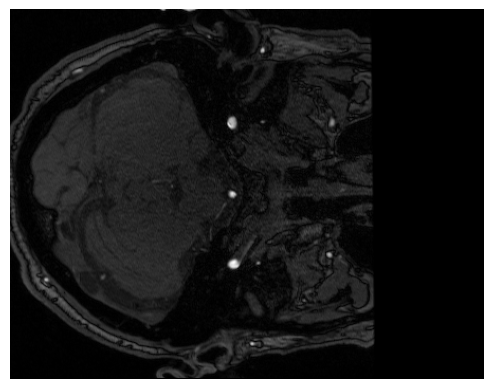

In [ ]:
# Select random layer number
maxval = depth
i = np.random.randint(0, maxval)
# Define a channel to look at
channel = 0
print(f"Plotting Layer {i} Channel {channel} of Image")
plt.imshow(image_data[:, :, i], cmap='gray')
plt.axis('off');

## PyTorch Data Loaders
Let's try to use the data loaders offered in medicaltorch to test the transformation functions. PyTorch offers a "transforms" module that helps us to apply any transformations on our data that we may wish, this is by stacking operations a seen below. First we resample the dataset so that all samples are of the same size and then apply a cropping area, followed by a tensor type transformation.

In [ ]:
# transformer
composed_transform = transforms.Compose([
            mt_transforms.Resample(0.25, 0.25),
            mt_transforms.CenterCrop2D((200, 200)),
            mt_transforms.ToTensor(),
])

In [ ]:
# load data
train_dataset = mt_datasets.SCGMChallenge2DTrain(root_dir=ROOT_DIR_GMCHALLENGE, transform=composed_transform)

In [ ]:
print(len(train_dataset))

2204


You can see an example below of how a raw image was converted to a tensor format.

In [ ]:
# sample of the training dataset
train_dataset[0]

{'gt': tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]]),
 'gt_metadata': <medicaltorch.datasets.SampleMetadata at 0x7f5071212fd0>,
 'input': tensor([[[  263.9700,   243.9216,   203.8249,  ...,  1864.4967,
            1690.7444,  1603.8682],
          [  245.5923,   226.3793,   187.9533,  ...,  1761.1224,
            1576.0929,  1483.5781],
          [  208.8370,   191.2947,   156.2101,  ...,  1554.3738,
            1346.7898,  1242.9978],
          ...,
          [  654.0775,   646.1417,   630.2701,  ...,   741.7890,
             706.7045,   689.1621],
          [  652.4068,   645.3063,   631.1055,  ...,  1040.8435,
             958.9795,   918.0474],
          [  651.5715,   644.8887,   631.5231,  ...,  1190.3708,
            1085.117

Now that we have the image loaded and transformed into tensors, we provided it to the PyTorch native Dataloader function to do its magic. The DataLoader below basically creates mini-batches and shuffles them.

In [ ]:
# PyTorch data loader
dataloader = DataLoader(train_dataset, batch_size=4,
                        shuffle=True, num_workers=4,
                        collate_fn=mt_datasets.mt_collate)
minibatch = next(iter(dataloader))

In [ ]:
# check minibatch size
minibatch['input'].size()

torch.Size([4, 1, 200, 200])

### Visualizing Batches
Below we show you how to visualize batches.

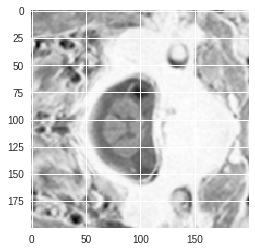

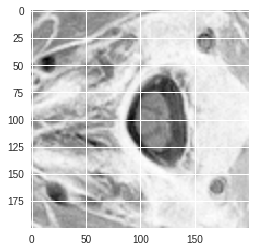

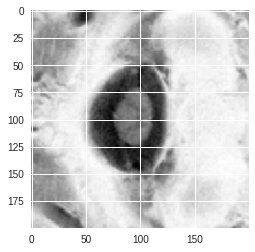

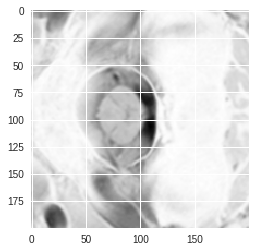

In [ ]:
for item in minibatch['input']:
    plt.imshow(item.squeeze(0))
    plt.show()

## Constructing The Segmentation Model
We saw the images above, now we want to build the gray matter segmentation model with the MRI spinal cord images provided above. Let's define a helper function that helps to decide the final predictions of the model.

In [ ]:
def threshold_predictions(predictions, thr=0.999):
    thresholded_preds = predictions[:]
    low_values_indices = thresholded_preds < thr
    thresholded_preds[low_values_indices] = 0
    low_values_indices = thresholded_preds >= thr
    thresholded_preds[low_values_indices] = 1
    return thresholded_preds

And here are all the transformations to both the training and validation dataset.

In [ ]:
train_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ElasticTransform(alpha_range=(28.0, 30.0),
                                       sigma_range=(3.5, 4.0),
                                       p=0.3),
        mt_transforms.RandomAffine(degrees=4.6,
                                   scale=(0.98, 1.02),
                                   translate=(0.03, 0.03)),
        mt_transforms.RandomTensorChannelShift((-0.10, 0.10)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

val_transform = transforms.Compose([
        mt_transforms.Resample(0.25, 0.25),
        mt_transforms.CenterCrop2D((200, 200)),
        mt_transforms.ToTensor(),
        mt_transforms.NormalizeInstance(),
])

In [ ]:
### training dataset with 80/20 split
TRAIN_ROOT_DIR_GMCHALLENGE = "/gdrive/My Drive/DAIR RESOURCES/PyTorch/medical_imaging/train/"

gmdataset_train = mt_datasets.SCGMChallenge2DTrain(root_dir=TRAIN_ROOT_DIR_GMCHALLENGE,
                                                   subj_ids=range(1, 9),
                                                   transform=train_transform,
                                                   slice_filter_fn=mt_filters.SliceFilter())

gmdataset_val = mt_datasets.SCGMChallenge2DTrain(root_dir=TRAIN_ROOT_DIR_GMCHALLENGE,
                                                 subj_ids=range(9, 11),
                                                 transform=val_transform)

In [ ]:
print(len(gmdataset_train))

1423


In [ ]:
train_loader = DataLoader(gmdataset_train, batch_size=16,
                          shuffle=True, pin_memory=True,
                          collate_fn=mt_datasets.mt_collate,
                          num_workers=1)

val_loader = DataLoader(gmdataset_val, batch_size=16,
                        shuffle=True, pin_memory=True,
                        collate_fn=mt_datasets.mt_collate,
                        num_workers=1)

### Model and Parameters
Below we declare our model and parameters. Note that we are using GPU in this notebook. Also note that the model used below refers to the U-net convolutional-based architecture proposed by [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597), which essentially aggregates semantic information to perform the segmentation. See a figure of the U-net framework below. You can also refer to the medicaltorch [API documentation](https://medicaltorch.readthedocs.io/en/stable/modules.html#module-medicaltorch.models) for more available state-of-the-art implementations.

![alt txt](https://docs.google.com/drawings/d/e/2PACX-1vT2miqwBsJpm9vX2lH7GRJaMWw3ym9Ld3MNY-10rpKIQJoXvfsRbIu1OpndIn4BJqYUtpq3wZcwmS9v/pub?w=921&h=624)

Image Credit: [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)

In [ ]:
model = mt_models.Unet(drop_rate=0.4, bn_momentum=0.1)
model.cuda()
num_epochs = 10
initial_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

Some helper functions to produce the desired metrics for the model such as accuracy.

In [ ]:
def numeric_score(prediction, groundtruth):
    FP = np.float(np.sum((prediction == 1) & (groundtruth == 0)))
    FN = np.float(np.sum((prediction == 0) & (groundtruth == 1)))
    TP = np.float(np.sum((prediction == 1) & (groundtruth == 1)))
    TN = np.float(np.sum((prediction == 0) & (groundtruth == 0)))
    return FP, FN, TP, TN

def accuracy(prediction, groundtruth):
    FP, FN, TP, TN = numeric_score(prediction, groundtruth)
    N = FP + FN + TP + TN
    accuracy = np.divide(TP + TN, N)
    return accuracy * 100.0

### Training
Now we finally train the model for spinal cord gray matter segmentation. We report the training and testing accuracy below and train for 10 epochs only.

In [ ]:
for epoch in tqdm(range(1, num_epochs+1)):
    start_time = time.time()

    scheduler.step()

    lr = scheduler.get_lr()[0]

    model.train()
    train_loss_total = 0.0
    num_steps = 0

    ### Training
    for i, batch in enumerate(train_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        var_input = input_samples.cuda()
        var_gt = gt_samples.cuda(async=True)

        preds = model(var_input)

        loss = mt_losses.dice_loss(preds, var_gt)
        train_loss_total += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        num_steps += 1

        if epoch % 5 == 0:
            grid_img = vutils.make_grid(input_samples,
                                        normalize=True,
                                        scale_each=True)


            grid_img = vutils.make_grid(preds.data.cpu(),
                                        normalize=True,
                                        scale_each=True)


            grid_img = vutils.make_grid(gt_samples,
                                        normalize=True,
                                        scale_each=True)


    train_loss_total_avg = train_loss_total / num_steps
    model.eval()
    val_loss_total = 0.0
    num_steps = 0
    train_acc  = accuracy(preds.cpu().detach().numpy(),
                          var_gt.cpu().detach().numpy())

    metric_fns = [mt_metrics.dice_score,
                  mt_metrics.hausdorff_score,
                  mt_metrics.precision_score,
                  mt_metrics.recall_score,
                  mt_metrics.specificity_score,
                  mt_metrics.intersection_over_union,
                  mt_metrics.accuracy_score]

    metric_mgr = mt_metrics.MetricManager(metric_fns)

    ### Validating
    for i, batch in enumerate(val_loader):
        input_samples, gt_samples = batch["input"], batch["gt"]

        with torch.no_grad():
            var_input = input_samples.cuda()
            var_gt = gt_samples.cuda(async=True)

            preds = model(var_input)
            loss = mt_losses.dice_loss(preds, var_gt)
            val_loss_total += loss.item()

        # Metrics computation
        gt_npy = gt_samples.numpy().astype(np.uint8)
        gt_npy = gt_npy.squeeze(axis=1)

        preds = preds.data.cpu().numpy()
        preds = threshold_predictions(preds)
        preds = preds.astype(np.uint8)
        preds = preds.squeeze(axis=1)

        metric_mgr(preds, gt_npy)

        num_steps += 1

    metrics_dict = metric_mgr.get_results()
    metric_mgr.reset()
    val_loss_total_avg = val_loss_total / num_steps

    print('\nTrain loss: {:.4f}, Training Accuracy: {:.4f} '.format(train_loss_total_avg, train_acc))
    print('Val Loss: {:.4f}, Validation Accuracy: {:.4f} '.format(val_loss_total_avg, metrics_dict["accuracy_score"]))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1749: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1311: RuntimeWarning: invalid value encountered in double_scalars
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))
 10%|█         | 1/10 [02:18<20:42, 138.06s/it]


Train loss: -0.4326, Training Accuracy: 83.7934 
Val Loss: -0.8337, Validation Accuracy: 99.0838 


 20%|██        | 2/10 [04:00<16:59, 127.42s/it]


Train loss: -0.8463, Training Accuracy: 95.3780 
Val Loss: -0.9135, Validation Accuracy: 99.5229 


 30%|███       | 3/10 [05:43<14:00, 120.09s/it]


Train loss: -0.8845, Training Accuracy: 92.9551 
Val Loss: -0.9218, Validation Accuracy: 99.5451 


 40%|████      | 4/10 [07:26<11:29, 114.91s/it]


Train loss: -0.9009, Training Accuracy: 94.8983 
Val Loss: -0.9235, Validation Accuracy: 99.5632 


 50%|█████     | 5/10 [09:12<09:21, 112.29s/it]


Train loss: -0.9107, Training Accuracy: 96.3178 
Val Loss: -0.9240, Validation Accuracy: 99.5627 


 60%|██████    | 6/10 [10:55<07:17, 109.40s/it]


Train loss: -0.9156, Training Accuracy: 95.7523 
Val Loss: -0.9252, Validation Accuracy: 99.5817 


 70%|███████   | 7/10 [12:38<05:22, 107.44s/it]


Train loss: -0.9206, Training Accuracy: 96.4490 
Val Loss: -0.9251, Validation Accuracy: 99.5695 


 80%|████████  | 8/10 [14:21<03:32, 106.08s/it]


Train loss: -0.9248, Training Accuracy: 96.6010 
Val Loss: -0.9236, Validation Accuracy: 99.5680 


 90%|█████████ | 9/10 [16:03<01:45, 105.01s/it]


Train loss: -0.9273, Training Accuracy: 96.8791 
Val Loss: -0.9260, Validation Accuracy: 99.5777 


100%|██████████| 10/10 [17:49<00:00, 105.36s/it]


Train loss: -0.9267, Training Accuracy: 97.0087 
Val Loss: -0.9262, Validation Accuracy: 99.5775 


## Final Words
In summary, you learned how to process MRI image scans using a neat and powerful tool known as medicaltorch. In addition, you learned about how to preprocess, prepare and load the data using medicaltorch and PyTorch's build-in DataLoader module. Finally, you trained a model based on convolutional neural networks to conduct spinal cord gray matter segmentation. Feel free to explore more of the utility function provided in the medicaltorch API and explore different types of datasets. Until next time!